# Predicting water temperature by salinity and other factors

**Task Description:**  
Training a machine learning model to predict the temperature of water depending on salinity and many other factors.  
**Data Description**  
The CalCOFI data set represents the longest (1949-present) and most complete (more than 50,000 sampling stations) time series of oceanographic and larval fish data in the world. It includes abundance data on the larvae of over 250 species of fish; larval length frequency data and egg abundance data on key commercial species; and oceanographic and plankton data. The physical, chemical, and biological data collected at regular time and space intervals quickly became valuable for documenting climatic cycles in the California Current and a range of biological responses to them.

#### iPython Notebook Sections
1. Import required libraries
2. Data loading
3. Dimensionality reduction
   1. remove all coulmns that have missing values more than 10% of their values.
   2. remove all rows that have missing values in thier T_degC coulumn.
   3. remove all rows that have missing values more that 10% of their values.  
   4. remove all features (columns) that have weak correlation with the temperature of water.  
4. Multiple regression model building, training and testing.  
5. Evaluation of prediction model.

**1. Import required libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

**2. Data loading**

In [2]:
bottle_data = pd.read_csv("/Users/HASAN/Desktop/machine learning projects/Water temperature prediction/datasets/bottle.csv")
print(bottle_data.shape)

C:\Users\HASAN\AppData\Local\Temp\ipykernel_19032\1459099090.py:1: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  bottle_data = pd.read_csv("/Users/HASAN/Desktop/machine learning projects/Water temperature prediction/datasets/bottle.csv")


(864863, 74)


In [3]:
bottle_data = bottle_data.set_index("Btl_Cnt")
bottle_data.head()

,Cst_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
Btl_Cnt,,,,,,,,,,,,,,,,,,,,,
1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**delete unnecessary columns**

In [4]:
columns_to_drop = ["Cst_Cnt", "Sta_ID", "Depth_ID"]
bottle_data = bottle_data.drop(columns=columns_to_drop)

In [5]:
print(bottle_data.shape)
bottle_data.head()

(864863, 70)


,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,BtlNum,RecInd,T_prec,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
Btl_Cnt,,,,,,,,,,,,,,,,,,,,,
1,0,10.50,33.440,NaN,25.649,NaN,NaN,NaN,3,1.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,10.46,33.440,NaN,25.656,NaN,NaN,NaN,3,2.0,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,10.46,33.437,NaN,25.654,NaN,NaN,NaN,7,2.0,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19,10.45,33.420,NaN,25.643,NaN,NaN,NaN,3,2.0,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20,10.45,33.421,NaN,25.643,NaN,NaN,NaN,7,2.0,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**3. Dimensionality reduction**

Dimensionality reduction steps will be as following:  
1. remove all coulmns that have missing values more than 10% of their values.
2. remove all rows that have missing values in thier T_degC coulumn cause it is the value that we want to train our model to predict it and it cannot be a missing value.
3. remove all rows that have missing values more that 75% of their values.
4. remove all features (columns) that have weak correlation with the temperature of water.

**A. remove all coulmns that have missing values more than 10% of their values**

In [6]:
null_counts_ratio = bottle_data.isnull().sum() / bottle_data.shape[0]
print("feature         null/all_values ratio")
for feature, value in null_counts_ratio.items():
    print(feature, value, sep="\t\t")

feature         null/all_values ratio
Depthm		0.0
T_degC		0.012675996082616553
Salnty		0.054753180561545586
O2ml_L		0.19501585800294383
STheta		0.06092178761260454
O2Sat		0.2354002888318728
Oxy_µmol/Kg		0.2354072263468318
BtlNum		0.8627909853930622
RecInd		0.0
T_prec		0.012675996082616553
T_qual		0.9732593485904704
S_prec		0.054753180561545586
S_qual		0.9133805007267047
P_qual		0.22096910146462503
O_qual		0.7864679145714408
SThtaq		0.923891992142108
O2Satq		0.7481716757451758
ChlorA		0.7395286883587343
Chlqua		0.26096271895086276
Phaeop		0.7395298446112274
Phaqua		0.26095809394089003
PO4uM		0.5221011882806872
PO4q		0.47762131112095213
SiO3uM		0.5905813984411404
SiO3qu		0.40930991382450166
NO2uM		0.6096769083658337
NO2q		0.3877943674316048
NO3uM		0.609876940047152
NO3q		0.38726364753724
NH3uM		0.924887525538727
NH3q		0.06540226602363611
C14As1		0.9833129640185787
C14A1p		0.985246218187158
C14A1q		0.01879835303394873
C14As2		0.9833337765634557
C14A2p		0.985267030732035
C14A2q		0.01877754

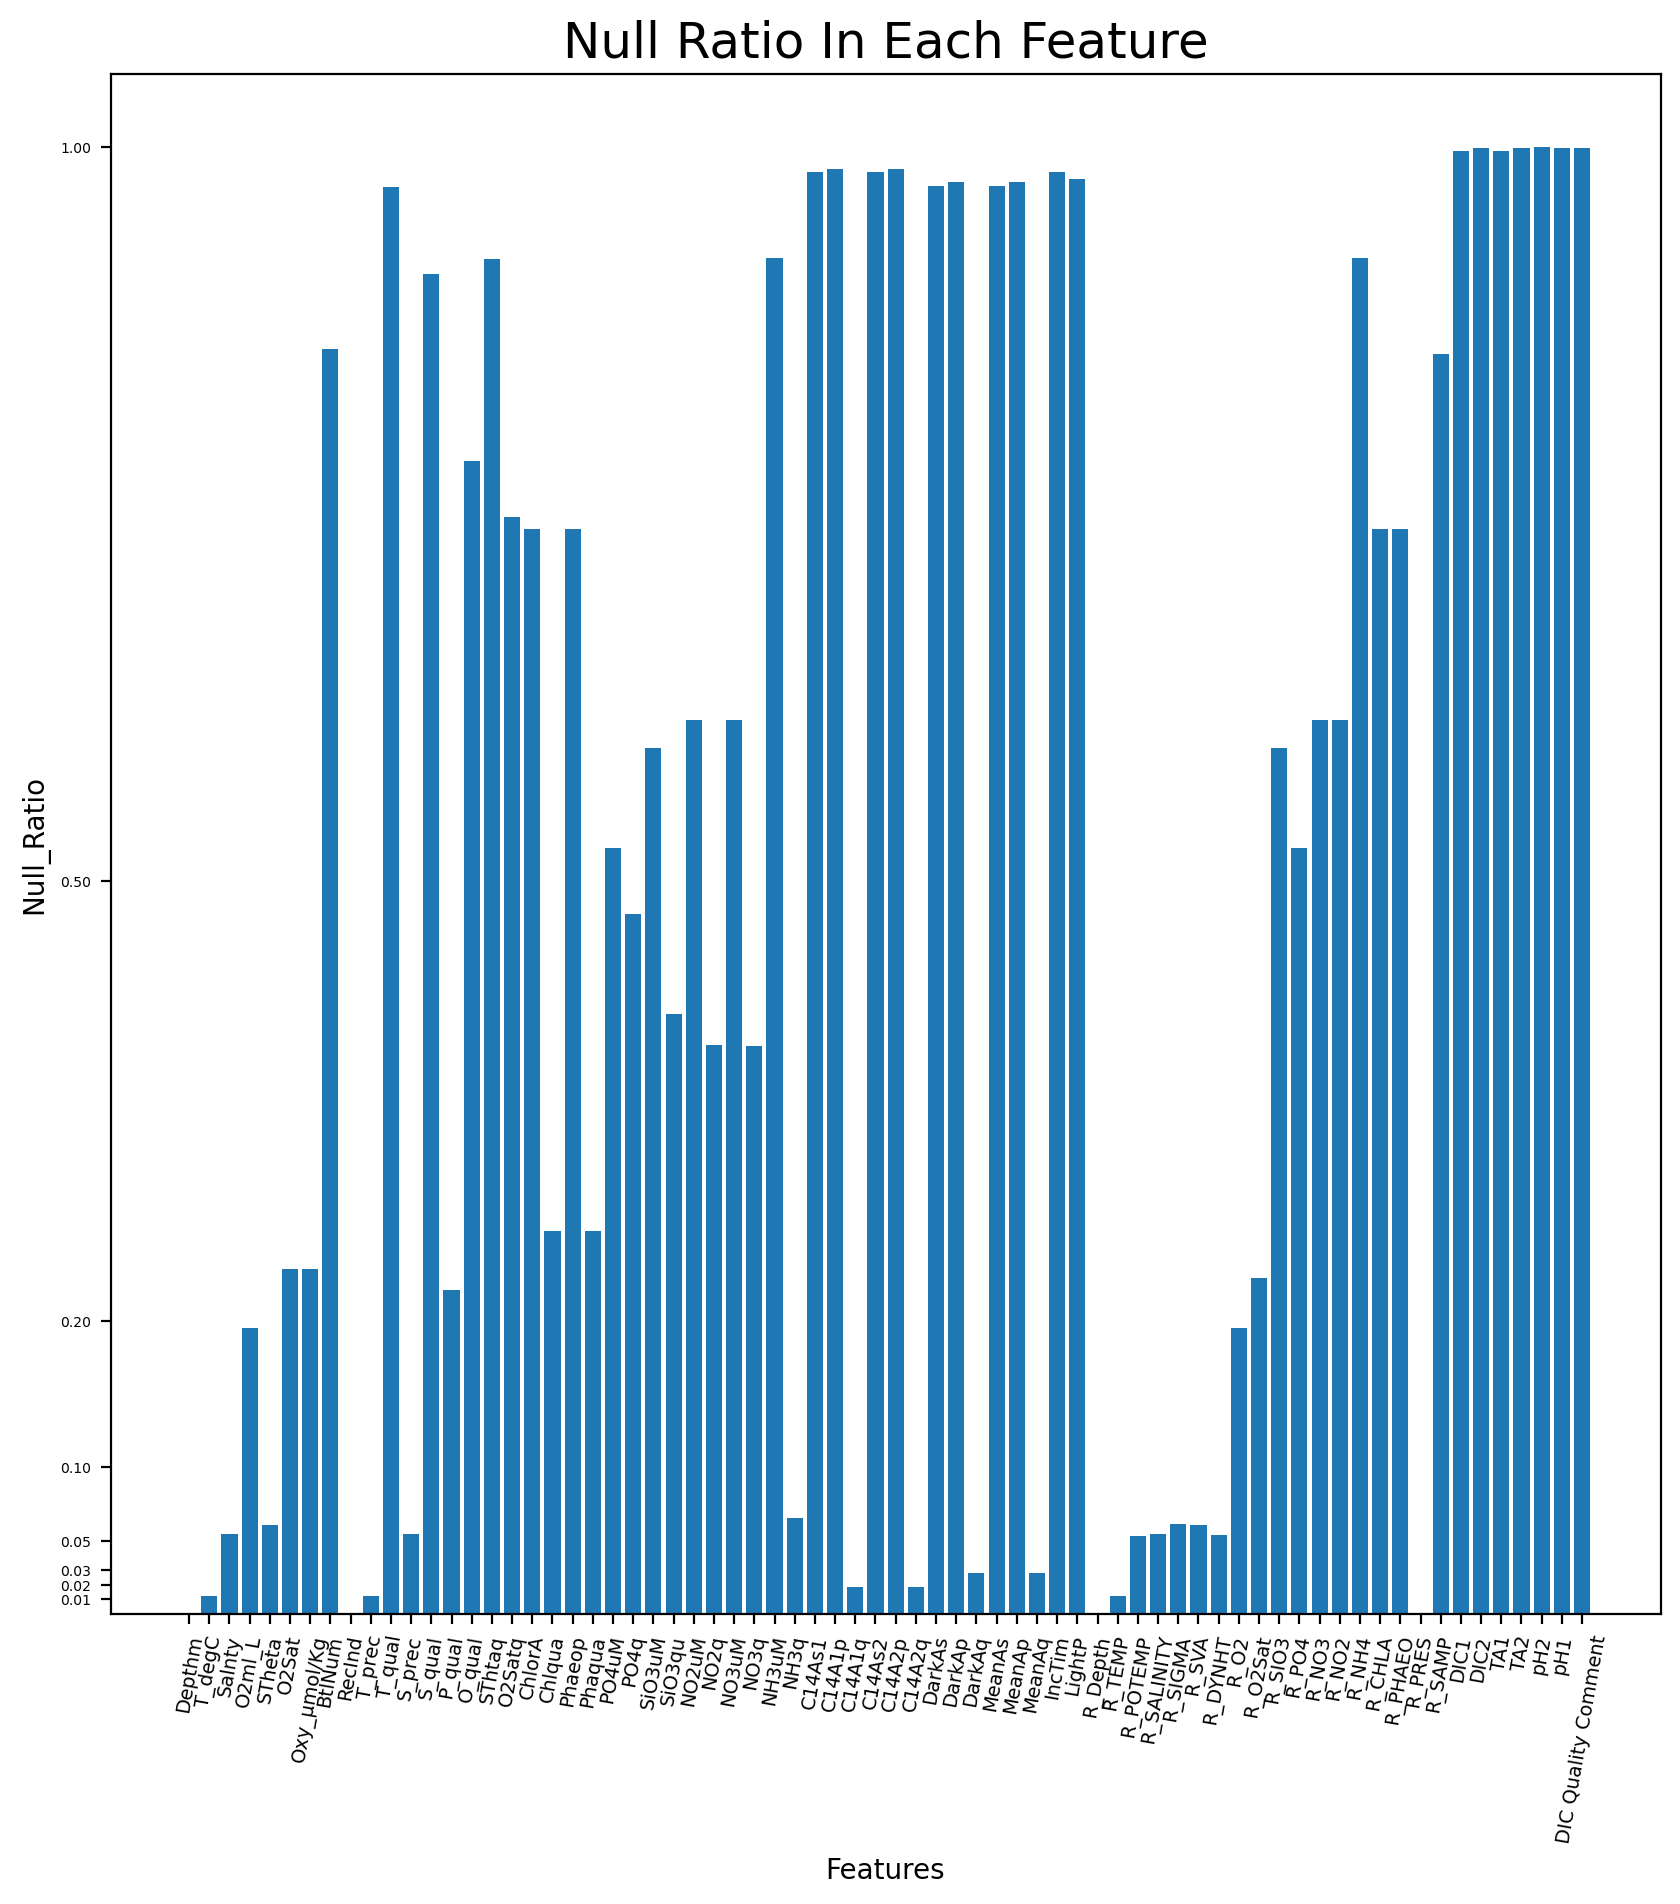

In [7]:
# plot null ration in each column to set the appropriate threshold
plt.figure(figsize=(10, 10), dpi=200)
plt.bar(bottle_data.columns.tolist(), null_counts_ratio)
plt.title("Null Ratio In Each Feature", fontsize=18)
plt.xlabel("Features")
plt.ylabel("Null_Ratio")
plt.xticks(rotation=80, fontsize=7)
plt.yticks([0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.5, 1], fontsize=5)
plt.show()

according to the previous graph, I chose to selete all features that have missing values (NaN) more than 10% of their values.

In [8]:
null_counts_ratio[null_counts_ratio > 0.1].shape

(50,)

As we see, 50 features have missing values more than 10% of their values so I will delete these columns in the next preprocessing step.

In [9]:
columns_to_drop = [feature for feature, null_ratio in null_counts_ratio.items() if null_ratio > 0.1]
print("features names that should be deleted are: ")
columns_to_drop

features names that should be deleted are: 


['O2ml_L',
 'O2Sat',
 'Oxy_µmol/Kg',
 'BtlNum',
 'T_qual',
 'S_qual',
 'P_qual',
 'O_qual',
 'SThtaq',
 'O2Satq',
 'ChlorA',
 'Chlqua',
 'Phaeop',
 'Phaqua',
 'PO4uM',
 'PO4q',
 'SiO3uM',
 'SiO3qu',
 'NO2uM',
 'NO2q',
 'NO3uM',
 'NO3q',
 'NH3uM',
 'C14As1',
 'C14A1p',
 'C14As2',
 'C14A2p',
 'DarkAs',
 'DarkAp',
 'MeanAs',
 'MeanAp',
 'IncTim',
 'LightP',
 'R_O2',
 'R_O2Sat',
 'R_SIO3',
 'R_PO4',
 'R_NO3',
 'R_NO2',
 'R_NH4',
 'R_CHLA',
 'R_PHAEO',
 'R_SAMP',
 'DIC1',
 'DIC2',
 'TA1',
 'TA2',
 'pH2',
 'pH1',
 'DIC Quality Comment']

In [10]:
# delete these features from the data set
bottle_data = bottle_data.drop(columns=columns_to_drop)
bottle_data.shape

(864863, 20)

As we can see in the previous output that number of remaining features is 20, **_Note:_** one of them is water temperature and the rest are the potential features that hopefully there is a good correlation between them and water temperature.

**B. remove all rows that have missing values in thier T_degC coulumn**

In [11]:
bottle_data = bottle_data.dropna(subset="T_degC")
bottle_data.shape

(853900, 20)

As we can see in the previous output, I deleted around 10k rows cause they have missing values in the T_degC cell.

**C. remove all rows that have missing values more that 30% of their values**

In [12]:
rows_null_ratio = bottle_data.isnull().sum(axis=1) / bottle_data.shape[1]
rows_null_ratio

Btl_Cnt
1         0.00
2         0.00
3         0.00
4         0.00
5         0.00
          ... 
864859    0.05
864860    0.00
864861    0.00
864862    0.05
864863    0.05
Length: 853900, dtype: float64

In [13]:
rows_to_drop = [index for index, null_ratio in rows_null_ratio.items() if null_ratio > 0.1]
print(len(rows_to_drop))

56738


In [14]:
bottle_data = bottle_data.drop(rows_to_drop)
print(bottle_data.shape)
bottle_data.head(20000)

(797162, 20)


,Depthm,T_degC,Salnty,STheta,RecInd,T_prec,S_prec,NH3q,C14A1q,C14A2q,DarkAq,MeanAq,R_Depth,R_TEMP,R_POTEMP,R_SALINITY,R_SIGMA,R_SVA,R_DYNHT,R_PRES
Btl_Cnt,,,,,,,,,,,,,,,,,,,,
1,0,10.50,33.440,25.649,3,1.0,2.0,9.0,9.0,9.0,9.0,9.0,0.0,10.50,10.50,33.440,25.64,233.0,0.00,0
2,8,10.46,33.440,25.656,3,2.0,2.0,9.0,9.0,9.0,9.0,9.0,8.0,10.46,10.46,33.440,25.65,232.5,0.01,8
3,10,10.46,33.437,25.654,7,2.0,3.0,9.0,9.0,9.0,9.0,9.0,10.0,10.46,10.46,33.437,25.65,232.8,0.02,10
4,19,10.45,33.420,25.643,3,2.0,2.0,9.0,9.0,9.0,9.0,9.0,19.0,10.45,10.45,33.420,25.64,234.1,0.04,19
5,20,10.45,33.421,25.643,7,2.0,3.0,9.0,9.0,9.0,9.0,9.0,20.0,10.45,10.45,33.421,25.64,234.0,0.04,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20617,200,8.58,33.902,26.328,7,2.0,3.0,9.0,9.0,9.0,9.0,9.0,200.0,8.58,8.56,33.902,26.32,172.4,0.55,201
20618,228,8.38,33.980,26.420,3,2.0,2.0,9.0,9.0,9.0,9.0,9.0,228.0,8.38,8.36,33.980,26.42,164.2,0.60,229
20619,250,8.17,34.046,26.503,7,2.0,3.0,9.0,9.0,9.0,9.0,9.0,250.0,8.17,8.14,34.046,26.50,156.5,0.63,251


**D. Remove all features that have weak correlation with the temperature of water**

In [15]:
# substitute the missing values with other values using interpolation approach
bottle_data = bottle_data.interpolate()

In [16]:
features = bottle_data.drop(columns="T_degC").columns.tolist()
T_degC = bottle_data["T_degC"].tolist()
print("The remaining features are: " ,*features)

The remaining features are:  Depthm Salnty STheta RecInd T_prec S_prec NH3q C14A1q C14A2q DarkAq MeanAq R_Depth R_TEMP R_POTEMP R_SALINITY R_SIGMA R_SVA R_DYNHT R_PRES


In [17]:
bottle_data.shape

(797162, 20)

In [18]:
correlation, p_value = dict(), dict()
for feature in features:
    feat = bottle_data[feature].tolist()
    corr, p = pearsonr(T_degC, feat)
    correlation[feature] = corr
    p_value[feature] = p

In [19]:
print("the correlation between each feature and the temperature of water is as following: ")
print(correlation)

the correlation between each feature and the temperature of water is as following: 
{'Depthm': -0.6755666290041893, 'Salnty': -0.4987109549368148, 'STheta': -0.8254256026872515, 'RecInd': -0.05805753462166628, 'T_prec': -0.045535135239479406, 'S_prec': -0.04773954306442786, 'NH3q': -0.008468694543042256, 'C14A1q': -0.004262587327594014, 'C14A2q': -0.004262587327594014, 'DarkAq': -0.004335195174184599, 'MeanAq': -0.004262587327594014, 'R_Depth': -0.6755650495695142, 'R_TEMP': 0.9999999911031622, 'R_POTEMP': 0.999952873493463, 'R_SALINITY': -0.49870661339652445, 'R_SIGMA': -0.859419167519432, 'R_SVA': 0.9636969262699118, 'R_DYNHT': -0.7917366381208683, 'R_PRES': -0.6741841202288366}


In [20]:
features_to_drop = [index for index, corr_value in correlation.items() if corr_value > -0.3 and corr_value < 0.3]
features_to_drop

['RecInd', 'T_prec', 'S_prec', 'NH3q', 'C14A1q', 'C14A2q', 'DarkAq', 'MeanAq']

In [21]:
bottle_data = bottle_data.drop(columns=features_to_drop)
bottle_data.shape

(797162, 12)

**E. Remove columns that contain the same features but measured by different methods**

In [22]:
# features that calculate temperature degree using different methods
columns_to_drop = ["R_TEMP", "R_POTEMP"]
# features that calculate Depth and salinity using different methods
columns_to_drop += ["R_Depth", "R_SALINITY"]
bottle_data = bottle_data.drop(columns=columns_to_drop)

**4. Multiple regression model building, training and testing**

In [23]:
independent_variables = bottle_data.columns.tolist()
independent_variables.remove("T_degC")
dependent_variables = "T_degC"
print("number of features after preprocessing is:", len(independent_variables)) 

number of features after preprocessing is: 7


In [24]:
X = bottle_data[independent_variables]
Y = bottle_data["T_degC"]
print(X.shape)
print(Y.shape)

(797162, 7)
(797162,)


In [25]:
X_train, X_test,  Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=39)

In [26]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(637729, 7) (637729,) (159433, 7) (159433,)


In [27]:
X_train.head()

,Depthm,Salnty,STheta,R_SIGMA,R_SVA,R_DYNHT,R_PRES
Btl_Cnt,,,,,,,
426757,10,33.689,23.664,23.660,422.5,0.040,10
805039,75,33.030,25.298,25.298,268.1,0.246,75
331001,500,34.059,26.875,26.870,123.0,0.990,503
583655,300,34.023,26.686,26.680,139.3,0.640,302
505029,200,34.040,26.267,26.260,178.7,0.550,201


In [28]:
poly = PolynomialFeatures(degree = 3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [29]:
len(X_train_poly[0])

120

In [30]:
lin_model = make_pipeline(StandardScaler(), Ridge())
param_grid = {'ridge__alpha': [0.1, 1.0, 10.0]}

lin_model = GridSearchCV(estimator=lin_model,
                         param_grid = param_grid,
                         cv=10)

lin_model.fit(X_train_poly, Y_train)

print("Best Parameters:\n", lin_model.best_params_)

# Select best log model
best_lin = lin_model.best_estimator_

# Make predictions using the optimised parameters
Y_pred = best_lin.predict(X_test_poly)

Best Parameters:
 {'ridge__alpha': 10.0}


**5. Evaluation of prediction model**

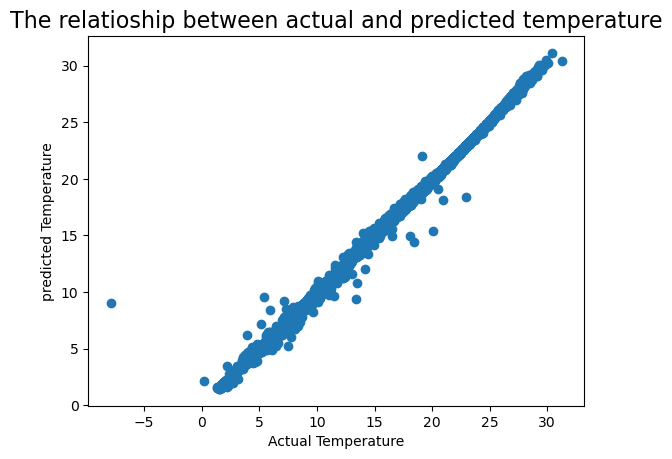

In [31]:
plt.scatter(Y_pred, Y_test)
plt.title("The relatioship between actual and predicted temperature", fontsize=16)
plt.xlabel("Actual Temperature")
plt.ylabel("predicted Temperature")
plt.show()

As we can see in the previous plot, there is a very good relationship between the actual and predicted temperature values and we can say that almosltly the eqyation of the previous is y = x

calculate of evaluation parameters to assess our prediction model goodness

In [32]:
# Calculate R-squared
r2 = r2_score(Y_test, Y_pred)

# Calculate mean squared error (MSE)
mse = mean_squared_error(Y_test, Y_pred)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(Y_test, Y_pred)

In [33]:
print("R-squared is:", r2)
print("mean squared error is:", mse)
print("mean absolute error is:", mae)

R-squared is: 0.999675227438947
mean squared error is: 0.005802578425200124
mean absolute error is: 0.03291052760174622


As we can see through the evaluation values, R_squared is more than 0.99 and this means that the selected features (independent variables) can explain most of the variance in the water temperature (dependent variable) and the small values of mean squared error and mean absolute error refer to a very good prediction.